In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt

REPO_ROOT = Path.cwd().parent.parent
ART = REPO_ROOT / "model" / "notebooks" / "artifacts"

print("Artifacts:", ART)

Artifacts: c:\capstone_project_unfc\model\notebooks\artifacts


In [32]:
FILES = {
    "Baseline (EWM)": "pred_baseline_weekly_price.parquet",
    "Prophet": "pred_prophet_weekly_price.parquet",
    #"LSTM": "pred_lstm_weekly_price.parquet",
    "XGBoost": "pred_xgb_weekly_price.parquet",
    "Chronos": "pred_chronos_weekly_price.parquet",
    "Chronos+XGBoost Ensemble":"pred_chronos_xgb_weekly_price.parquet",
    "Prophet+XGBoost Ensemble":"pred_ensemble_weekly_price.parquet",	
}

missing = [f for f in FILES.values() if not (ART / f).exists()]
if missing:
    print(" Missing prediction parquet files:")
    for m in missing:
        print("  -", m)
    raise FileNotFoundError("Generate missing parquet artifacts first, then rerun.")

print("All prediction files found.")

All prediction files found.


In [33]:
def load_pred(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path).copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").set_index("timestamp")
    return df[["y_true", "y_pred"]]

preds = {name: load_pred(ART / fname) for name, fname in FILES.items()}
{k: v.shape for k, v in preds.items()}

{'Baseline (EWM)': (30, 2),
 'Prophet': (30, 2),
 'XGBoost': (30, 2),
 'Chronos': (30, 2),
 'Chronos+XGBoost Ensemble': (30, 2),
 'Prophet+XGBoost Ensemble': (30, 2)}

In [34]:
for name, df in preds.items():
    print("\n==", name, "==")
    print("rows:", len(df))
    print("index dtype:", df.index.dtype)
    if len(df) > 0:
        print("min:", df.index.min(), "max:", df.index.max())
        print("head timestamps:", df.index[:3].tolist())
        print("tail timestamps:", df.index[-3:].tolist())


== Baseline (EWM) ==
rows: 30
index dtype: datetime64[ms]
min: 2025-08-04 00:00:00 max: 2026-02-23 00:00:00
head timestamps: [Timestamp('2025-08-04 00:00:00'), Timestamp('2025-08-11 00:00:00'), Timestamp('2025-08-18 00:00:00')]
tail timestamps: [Timestamp('2026-02-09 00:00:00'), Timestamp('2026-02-16 00:00:00'), Timestamp('2026-02-23 00:00:00')]

== Prophet ==
rows: 30
index dtype: datetime64[ms]
min: 2025-08-04 00:00:00 max: 2026-02-23 00:00:00
head timestamps: [Timestamp('2025-08-04 00:00:00'), Timestamp('2025-08-11 00:00:00'), Timestamp('2025-08-18 00:00:00')]
tail timestamps: [Timestamp('2026-02-09 00:00:00'), Timestamp('2026-02-16 00:00:00'), Timestamp('2026-02-23 00:00:00')]

== XGBoost ==
rows: 30
index dtype: datetime64[ms]
min: 2025-07-28 00:00:00 max: 2026-02-16 00:00:00
head timestamps: [Timestamp('2025-07-28 00:00:00'), Timestamp('2025-08-04 00:00:00'), Timestamp('2025-08-11 00:00:00')]
tail timestamps: [Timestamp('2026-02-02 00:00:00'), Timestamp('2026-02-09 00:00:00'), T

In [35]:
import pandas as pd

for name, df in preds.items():
    if len(df) > 0:
        # 1. Convert to timezone-naive UTC to ensure consistency
        if df.index.tz is not None:
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        else:
            df.index = df.index.tz_localize(None)
            
        # 2. Round to the nearest day (if needed) to fix minor ms offsets
        df.index = df.index.normalize()
        
        preds[name] = df

print("Indexes unified!")

Indexes unified!


In [36]:
names = list(preds.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        inter = preds[a].index.intersection(preds[b].index)
        print(f"{a} ∩ {b}: {len(inter)}")

Baseline (EWM) ∩ Prophet: 30
Baseline (EWM) ∩ XGBoost: 29
Baseline (EWM) ∩ Chronos: 30
Baseline (EWM) ∩ Chronos+XGBoost Ensemble: 29
Baseline (EWM) ∩ Prophet+XGBoost Ensemble: 30
Prophet ∩ XGBoost: 29
Prophet ∩ Chronos: 30
Prophet ∩ Chronos+XGBoost Ensemble: 29
Prophet ∩ Prophet+XGBoost Ensemble: 30
XGBoost ∩ Chronos: 29
XGBoost ∩ Chronos+XGBoost Ensemble: 30
XGBoost ∩ Prophet+XGBoost Ensemble: 29
Chronos ∩ Chronos+XGBoost Ensemble: 29
Chronos ∩ Prophet+XGBoost Ensemble: 30
Chronos+XGBoost Ensemble ∩ Prophet+XGBoost Ensemble: 29


In [37]:
common = None
for df in preds.values():
    common = df.index if common is None else common.intersection(df.index)

print("Common points:", len(common), "|", common.min(), "→", common.max())
preds = {k: v.loc[common].copy() for k, v in preds.items()}

# y_true sanity check
y_ref = next(iter(preds.values()))["y_true"].to_numpy()
for k, v in preds.items():
    if not np.allclose(v["y_true"].to_numpy(), y_ref, rtol=1e-9, atol=1e-9):
        print("y_true mismatch for:", k)

Common points: 29 | 2025-08-04 00:00:00 → 2026-02-16 00:00:00
y_true mismatch for: Chronos
y_true mismatch for: Chronos+XGBoost Ensemble


In [38]:
def compute_metrics(df: pd.DataFrame):
    y = df["y_true"].to_numpy(dtype=float)
    yhat = df["y_pred"].to_numpy(dtype=float)
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat)**2))
    mape = np.mean(np.abs((y - yhat) / y)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

rows = [{"Model": k, **compute_metrics(v)} for k, v in preds.items()]
results = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
results

,MAE,RMSE,MAPE_%
Model,,,
Chronos,5.756382,6.985120,3.144005
Prophet+XGBoost Ensemble,5.623475,7.052555,3.072910
Prophet,9.872360,12.623744,5.398209
XGBoost,11.672102,13.582441,6.287737
Baseline (EWM),13.623481,16.687806,7.409328
Chronos+XGBoost Ensemble,24.026495,31.700799,5.731939


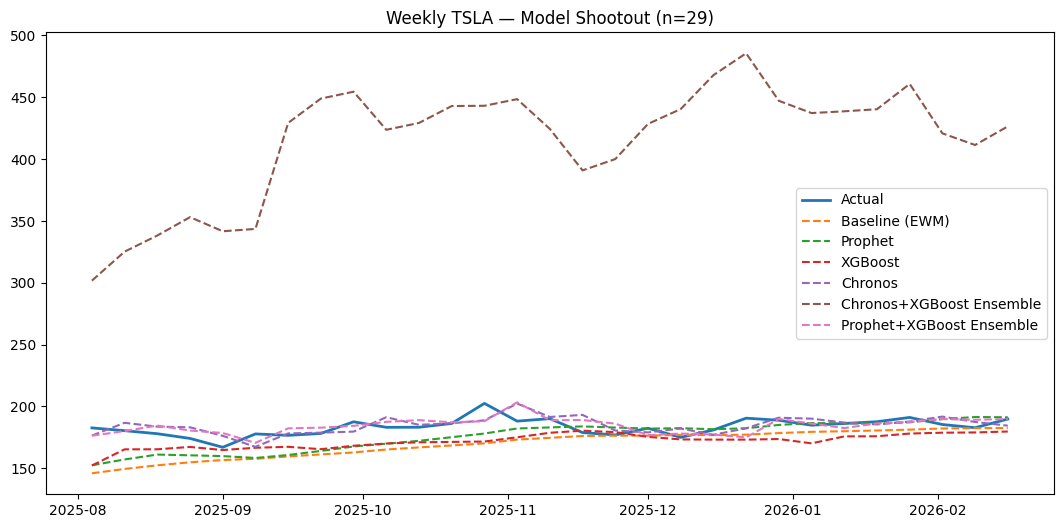

In [39]:
plot_df = pd.DataFrame(index=common)
plot_df["Actual"] = y_ref

for name, df in preds.items():
    plot_df[name] = df["y_pred"].to_numpy()

plt.figure(figsize=(13, 6))
plt.plot(plot_df.index, plot_df["Actual"], label="Actual", lw =2)
for name in preds.keys():
    plt.plot(plot_df.index, plot_df[name], label=name, ls ='--')

plt.title(f"Weekly TSLA — Model Shootout (n={len(plot_df)})")
plt.legend()
plt.show()